# Playground Self Supervised Learning: Fashionset Classification (FashionMNIST Dataset)

**Fashion MNIST** dataset ready in https://pytorch.org/docs/master/torchvision/datasets.html#fashion-mnist

In [1]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader
from torchvision.models import resnet101, resnet18, vgg19
from torchvision.datasets import FashionMNIST
from torchvision.transforms import Compose, ToTensor, Normalize, RandomRotation, ToPILImage

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Define a transform to normalize the data
transform = Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))])

In [4]:
root_dir = 'fashion_mnist'
batch_size=64

# Download and load the training data
trainset = FashionMNIST(root=root_dir, download=True, train=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

# Download and load the test data
testset = FashionMNIST(root=root_dir, download=True, train=False, transform=transform)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=True)

In [5]:
image, label = trainset[0]
print(image.size())
print(label)

torch.Size([1, 28, 28])
9


In [6]:
#We can iterate over the dataset
for xs, ys in trainloader:
    print(xs.size(), ys.size())
    print(ys)
    break

torch.Size([64, 1, 28, 28]) torch.Size([64])
tensor([1, 5, 1, 8, 2, 0, 5, 2, 4, 2, 1, 3, 0, 2, 2, 5, 6, 8, 0, 4, 9, 5, 0, 9,
        1, 9, 4, 0, 5, 3, 0, 2, 9, 3, 6, 1, 0, 4, 1, 4, 3, 0, 8, 5, 8, 6, 1, 7,
        0, 9, 6, 3, 1, 9, 7, 8, 3, 3, 0, 9, 3, 3, 0, 7])


### Display random images

In [7]:
from matplotlib import pyplot as plt
from random import randint

f, axes = plt.subplots(2, 3, figsize=(12.8, 9.6))
axes = [ax for axs in axes for ax in axs]
for i in range(6):
    index = randint(0, len(trainset))
    axes[i].imshow(trainset[index][0].view(28, 28), cmap='gray')
    axes[i].axis('off')    

### Random rotation

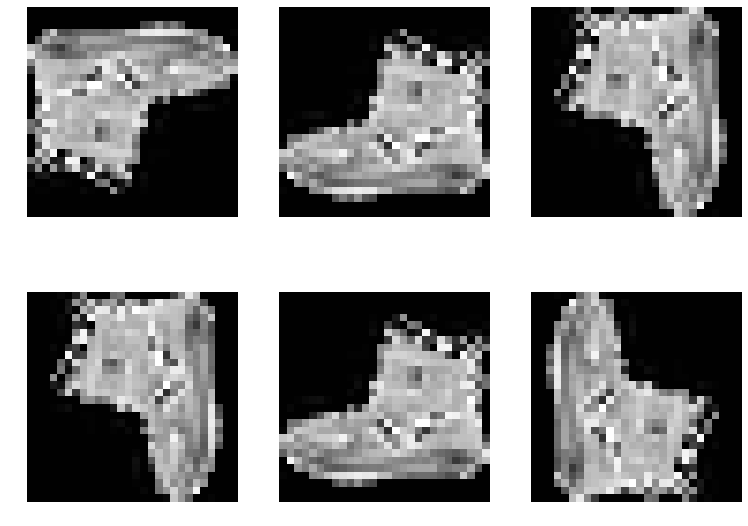

In [8]:
import torchvision.transforms.functional as TF
import random


transforms = ToPILImage()
    
f, axes = plt.subplots(2, 3, figsize=(12.8, 9.6))
axes = [ax for axs in axes for ax in axs]

for i in range(6):
    angle = random.choice([0, 90, 180, 270])
    axes[i].imshow(TF.rotate(transforms(trainset[0][0]), angle), cmap='gray')
    axes[i].axis('off') 

In [9]:
from torch.utils.data import Dataset

class FashionMinstAugmentedDataset(Dataset):

    def __init__(self, data, transform):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        datapoint = self.transform(self.data[index])

        return datapoint

In [26]:
def my_segmentation_transforms(image):
    angle = random.choice([0, 90, 180, 270])

    image = TF.to_pil_image(image[0])
    image = TF.rotate(image, angle)

    image = TF.to_tensor(image)
    image = TF.normalize(image, (0.5, ), (0.5, ))

    
    # need to use ints for classes [0, 90, 180, 270]
    if angle == 0:
        rotation_class = 0 
    if angle == 90:
        rotation_class = 1
    if angle == 180:
        rotation_class = 2
    if angle == 270:
        rotation_class = 3
    
    return image, rotation_class

In [27]:
trainset_augmented = FashionMinstAugmentedDataset(trainset, transform=my_segmentation_transforms)
trainloader_augmented = DataLoader(trainset_augmented, batch_size=batch_size, shuffle=True, num_workers=32)

torch.Size([1, 28, 28])
2


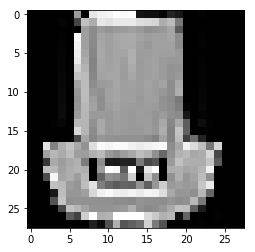

In [38]:
image, label = trainset_augmented[1]
plt.imshow(image.view(28, 28), cmap='gray')
print(image.size())
print(label)

In [39]:
#We can iterate over the dataset
for xs, ys in trainloader_augmented:
    print(xs.size(), ys.size())
    print(ys)
    break

torch.Size([64, 1, 28, 28]) torch.Size([64])
tensor([1, 2, 1, 1, 2, 0, 1, 0, 0, 0, 3, 1, 1, 2, 2, 3, 0, 2, 3, 0, 1, 3, 0, 1,
        0, 1, 1, 3, 1, 1, 1, 2, 2, 2, 1, 3, 1, 0, 0, 0, 3, 1, 2, 1, 3, 0, 2, 2,
        1, 2, 3, 3, 1, 3, 1, 2, 0, 1, 3, 0, 3, 3, 2, 0])


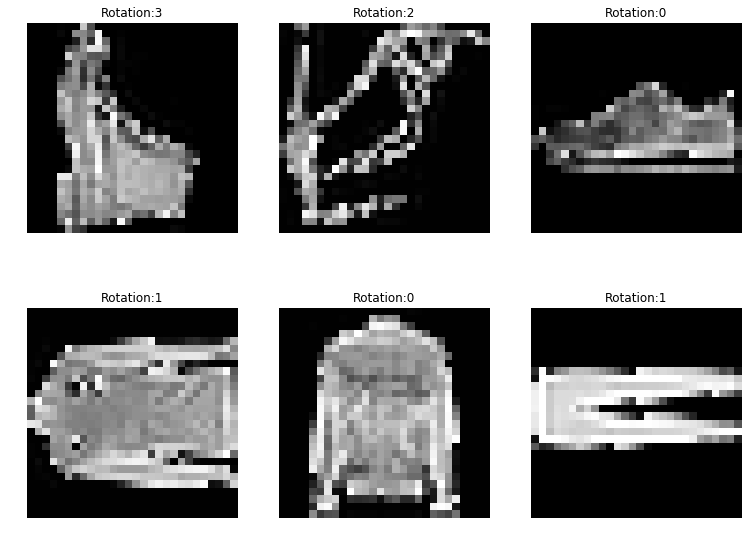

In [40]:
from matplotlib import pyplot as plt
from random import randint

f, axes = plt.subplots(2, 3, figsize=(12.8, 9.6))
axes = [ax for axs in axes for ax in axs]
for i in range(6):
    index = randint(0, len(trainset_augmented))
    image, label = trainset_augmented[index]
    axes[i].imshow(np.asarray(image.view(28, 28)), cmap='gray')
    axes[i].set_title('Rotation:' + str(label))
    axes[i].axis('off')   

## Models

#### Train

In [47]:
import copy

def train_model(model, loss_fn, optimizer, scheduler, num_epochs=25):

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        scheduler.step()
        model.train()
        
        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for inputs, labels in trainloader_augmented:
            inputs = inputs.to(device)
            labels = labels.to(device)
                        
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = loss_fn(outputs, labels)
                
                # backward + optimize only if in training phase
                loss.backward()
                optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(trainset_augmented)
        epoch_acc = running_corrects.double() / len(trainset_augmented)

        print('Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

        # deep copy the model
        # if phase == 'valid' and epoch_acc > best_acc:
        #     best_acc = epoch_acc
        #     best_model_wts = copy.deepcopy(model.state_dict())

    print()
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

#### ResNet 18

In [48]:
model_resnet18 = resnet18(pretrained=False)

In [49]:
model_resnet18.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
model_resnet18.avgpool = nn.AdaptiveAvgPool2d(1)
model_resnet18.fc = nn.Linear(16*32, 4)

In [50]:
# model_resnet18

In [51]:
# Criteria NLLLoss which is recommended with Softmax final layer
loss_fn = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optim = torch.optim.Adam(model_resnet18.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 4 epochs
sched = torch.optim.lr_scheduler.StepLR(optimizer=optim, step_size=4, gamma=0.1)

# Number of epochs
eps=10

In [52]:
model_ft = train_model(model_resnet18, loss_fn, optim, sched, eps)

Epoch 1/10
----------
Loss: 0.2407 Acc: 0.9159
Epoch 2/10
----------
Loss: 0.1317 Acc: 0.9546
Epoch 3/10
----------
Loss: 0.1052 Acc: 0.9643
Epoch 4/10
----------
Loss: 0.0929 Acc: 0.9681
Epoch 5/10
----------
Loss: 0.0551 Acc: 0.9819
Epoch 6/10
----------
Loss: 0.0455 Acc: 0.9842
Epoch 7/10
----------
Loss: 0.0413 Acc: 0.9861
Epoch 8/10
----------
Loss: 0.0374 Acc: 0.9872
Epoch 9/10
----------
Loss: 0.0325 Acc: 0.9889
Epoch 10/10
----------
Loss: 0.0294 Acc: 0.9898

Best val Acc: 0.000000


#### ResNet 101

In [113]:
model = resnet101(pretrained=False)

# show architecture of model
# model

In [119]:
model.fc = nn.Linear(16*32, 4)
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
model.avgpool = nn.AdaptiveAvgPool2d(1)

In [127]:
model

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [121]:
# Criteria NLLLoss which is recommended with Softmax final layer
loss_fn = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optim = torch.optim.Adam(model.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 4 epochs
sched = torch.optim.lr_scheduler.StepLR(optimizer=optim, step_size=4, gamma=0.1)

# Number of epochs
eps=10

In [122]:
model_ft = train_model(model, loss_fn, optim, sched, eps)

Epoch 1/10
----------
torch.Size([64, 1, 28, 28])
torch.Size([64])


RuntimeError: size mismatch, m1: [64 x 2048], m2: [784 x 4] at /Users/soumith/b101_2/2019_02_08/wheel_build_dirs/wheel_3.6/pytorch/aten/src/TH/generic/THTensorMath.cpp:940